# LTI CRN NETWORKS

In [1]:
from src.siso_analyzer import SISOAnalyzer
from src.make_lti_crn import makeLtiCrn  # type: ignore

import numpy as np
import pandas as pd
import tellurium as te
import matplotlib.pyplot as plt
from scipy import signal

# Making LTI Networks

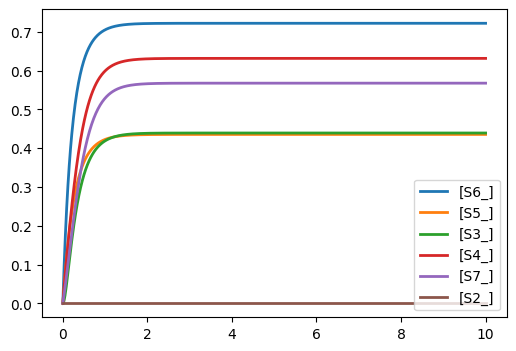

eigenvalues: [-15.11046782+0.j         -13.54575398+0.j
  -3.31174895+0.j          -6.42991463+1.05866434j
  -6.42991463-1.05866434j  -1.059     +0.j        ]
# Random Chemical Reaction Network
# Generated with specified constraints

model random_crn()

  species S1_;

  S6_ -> 3 S5_; k2 * S6_
  S6_ -> 2 S3_ + 2 S6_ + S5_; k3 * S6_
  S4_ -> 2 S7_ + S3_ + 3 S3_; k4 * S4_
  S5_ -> S7_ + S4_ + 3 S5_ + S3_; k5 * S5_
  S5_ -> 2 S3_ + S5_ + 3 S5_; k6 * S5_
  S7_ -> S6_ + 2 S5_ + 2 S7_; k7 * S7_
  S2_ -> S6_ + S5_ + 2 S5_ + 2 S6_; k8 * S2_
  S2_ -> 3 S5_ + 3 S5_ + 2 S3_; k9 * S2_
  S5_ -> 3 S6_ + S3_ + S7_ + 3 S3_; k10 * S5_
  S5_ -> 3 S4_ + 2 S7_ + S5_ + 3 S6_ + 3 S3_; k11 * S5_
  S3_ -> 2 S7_ + 2 S3_ + S4_ + 3 S4_; k12 * S3_
  S5_ -> 3 S6_ + 2 S3_; k13 * S5_
  S1_ -> S5_ + 3 S6_ + 3 S4_ + 2 S5_ + S6_; k14 * S1_
  S1_ -> S7_ + 2 S6_; k15 * S1_

  # Rate constants
  k2 = 0.7600
  k3 = 0.8663
  k4 = 0.7552
  k5 = 0.4695
  k6 = 0.3910
  k7 = 0.3427
  k8 = 0.5447
  k9 = 0.5143
  k10 = 0.5210
  k

In [2]:
MODEL = makeLtiCrn(num_species=7,
    num_reaction=15,
    num_products_bounds=[1, 5],
    kinetic_constant_bounds= (0.1, 1),
    stoichiometry_bounds=[1, 3],
    is_input_boundary=True)
rr = te.loada(MODEL)
DATA = rr.simulate(0, 10, 1000)
rr.plot()
mat = rr.getFullJacobian()
print(f"eigenvalues: {np.linalg.eigvals(mat)}")
print(MODEL)

# SISO Analysis

In [3]:
analyzer = SISOAnalyzer(MODEL, input_name="S1_")


In [14]:
JACOBIAN_ARR = analyzer.jacobian_df.values
JACOBIAN_ARR

array([[ -1.2607,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ],
       [  0.    ,  -1.059 ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ],
       [  0.    ,   1.0286, -14.0679,   3.0208,   6.9311,   1.7326,
          0.    ],
       [  1.4724,   0.    ,   3.3392,  -6.4247,   2.5701,   0.    ,
          0.    ],
       [  1.4724,   4.7199,   0.    ,   0.    ,  -9.4911,   3.1463,
          0.6854],
       [  3.503 ,   1.6341,   0.    ,   0.    ,   5.9061,  -8.6818,
          0.3427],
       [  0.7699,   0.    ,   1.6696,   1.5104,   2.3909,   0.    ,
         -6.1623]])

In [4]:
tf = analyzer.makeTransferFunction()
print(tf)

TransferFunctionContinuous(
array([7.69900000e-01, 3.55128426e+01, 6.38740972e+02, 5.27007543e+03,
       1.63420945e+04]),
array([1.00000000e+00, 4.48278000e+01, 7.53152110e+02, 5.88797441e+03,
       2.14388779e+04, 2.87849351e+04]),
dt: None
)


In [5]:
analyzer.transfer_function_smat

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [6]:
tf.poles

array([-15.11046782+0.j        , -13.54575398+0.j        ,
        -6.42991463+1.05866434j,  -6.42991463-1.05866434j,
        -3.31174895+0.j        ])

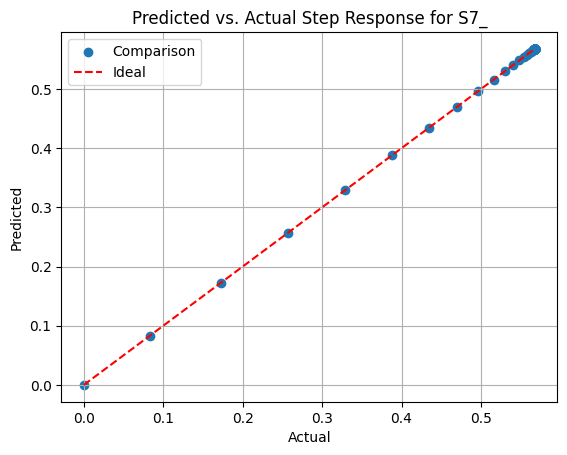

In [7]:
analyzer.plotTransferFunctionValidation()

In [8]:
tf_smat = analyzer.transfer_function_smat
tf_smat

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# Solving a linear system for steady state

In [24]:
import numpy as np

def solve_linear_system(A, b, fixed=None):
    """
    Solve Ax = b in the least-squares sense, with optional fixed coordinates.
    
    Args:
        A: matrix (m x n)
        b: right-hand side vector (length m)
        fixed: dict mapping coordinate index -> fixed value
               e.g., {0: 1.5, 3: 0.0} fixes x[0]=1.5 and x[3]=0.0
    
    Returns:
        x: solution
        residual: norm of (Ax - b)
        rank: effective rank of the (reduced) system
    """
    A = np.asarray(A, dtype=float)
    b = np.asarray(b, dtype=float)
    n = A.shape[1]
    
    if fixed is None:
        fixed = {}
    
    # Identify free vs fixed indices
    fixed_indices = sorted(fixed.keys())
    free_indices = [i for i in range(n) if i not in fixed]
    
    if not free_indices:
        # All coordinates fixed; just compute residual
        x = np.array([fixed[i] for i in range(n)])
        residual = np.linalg.norm(A @ x - b)
        return x, residual, 0
    
    # Move fixed terms to the right-hand side: A_free @ x_free = b - A_fixed @ x_fixed
    A_free = A[:, free_indices]
    A_fixed = A[:, fixed_indices]
    x_fixed = np.array([fixed[i] for i in fixed_indices])
    b_adjusted = b - A_fixed @ x_fixed
    
    # Solve reduced system
    x_free, residuals, rank, _ = np.linalg.lstsq(A_free, b_adjusted, rcond=None)
    
    # Reassemble full solution
    x = np.zeros(n)
    x[fixed_indices] = x_fixed
    x[free_indices] = x_free
    
    residual = np.linalg.norm(A @ x - b)
    
    return x, residual, rank


# Example usage
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

b = np.array([1, 2, 3])

A = JACOBIAN_ARR
b = np.zeros(A.shape[0])
# Specify that S1 is the step input and so must be 1 on output.
fixed_dct = {0: 1}

# Solve with x[0] fixed to 0.5
x, residual, rank = solve_linear_system(A, b, fixed=fixed_dct)

print(f"Solution: {x}")
print(f"Residual: {residual:.2e}")
print(f"Rank: {rank}")
print(f"Verification A @ x = {A @ x}")
print(f"Target b = {b}")

Solution: [1.00000000e+00 7.13885043e-17 4.39166992e-01 6.31663040e-01
 4.35539128e-01 7.22188831e-01 5.67730809e-01]
Residual: 5.96e-15
Rank: 6
Verification A @ x = [ 0.00000000e+00 -7.56004260e-17  0.00000000e+00  1.77635684e-15
  0.00000000e+00  3.55271368e-15 -4.44089210e-15]
Target b = [0. 0. 0. 0. 0. 0. 0.]


In [22]:
JACOBIAN_ARR

array([[  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ],
       [  0.    ,  -1.059 ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ],
       [  0.    ,   1.0286, -14.0679,   3.0208,   6.9311,   1.7326,
          0.    ],
       [  1.4724,   0.    ,   3.3392,  -6.4247,   2.5701,   0.    ,
          0.    ],
       [  1.4724,   4.7199,   0.    ,   0.    ,  -9.4911,   3.1463,
          0.6854],
       [  3.503 ,   1.6341,   0.    ,   0.    ,   5.9061,  -8.6818,
          0.3427],
       [  0.7699,   0.    ,   1.6696,   1.5104,   2.3909,   0.    ,
         -6.1623]])